<a href="https://colab.research.google.com/github/SharifulIslam08/ML/blob/master/detectron2_firstpractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!export LC_ALL=en_US.UTF-8

# Restart the kernel
import os
os.system('jupyter-kernelspec regenerate')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


256

In [22]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [23]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [24]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

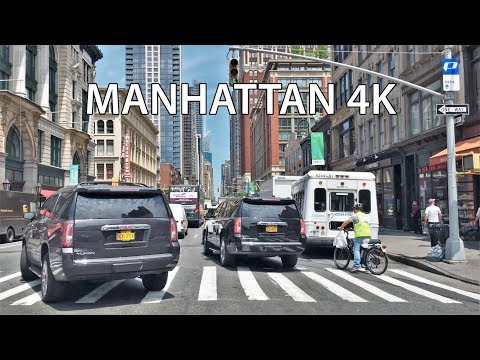

In [36]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ZvHXpd9uzN4", width=500)
display(video)

In [44]:
# !youtube-dl --proxy "http://your-proxy-server:port" https://www.youtube.com/watch?v=ZvHXpd9uzN4 -f 22 -o video.mp4
!pip install yt-dlp
!yt-dlp --verbose https://www.youtube.com/watch?v=ZvHXpd9uzN4 -f 22 -o video1.mp4

# Crop the video using ffmpeg (without locale changes)
!ffmpeg -i video1.mp4 -t 00:00:06 -c:v copy video-clip6.mp4


[debug] Command-line config: ['--verbose', 'https://www.youtube.com/watch?v=ZvHXpd9uzN4', '-f', '22', '-o', 'video1.mp4']
[debug] Encodings: locale UTF-8, fs utf-8, pref UTF-8, out utf-8, error utf-8, screen utf-8
[debug] yt-dlp version stable@2023.07.06 [b532a3481] (pip)
[debug] Python 3.10.12 (CPython x86_64 64bit) - Linux-5.15.109+-x86_64-with-glibc2.35 (OpenSSL 3.0.2 15 Mar 2022, glibc 2.35)
[debug] exe versions: ffmpeg 4.4.2 (setts), ffprobe 4.4.2
[debug] Optional libraries: Cryptodome-3.18.0, brotli-1.0.9, certifi-2023.07.22, mutagen-1.46.0, secretstorage-3.3.1, sqlite3-2.6.0, websockets-11.0.3
[debug] Proxy map: {'colab_language_server': '/usr/colab/bin/language_service'}
[debug] Loaded 1855 extractors
[youtube] Extracting URL: https://www.youtube.com/watch?v=ZvHXpd9uzN4
[youtube] ZvHXpd9uzN4: Downloading webpage
[youtube] ZvHXpd9uzN4: Downloading ios player API JSON
[youtube] ZvHXpd9uzN4: Downloading android player API JSON
[youtube] ZvHXpd9uzN4: Downloading m3u8 information
[d

In [45]:
# Download the results
from google.colab import files
files.download('video-clip6.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip6.mp4 --confidence-threshold 0.6 --output video-output6.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

fatal: destination path 'detectron2' already exists and is not an empty directory.
[08/11 16:49:58 detectron2]: Arguments: Namespace(config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', webcam=False, video_input='video-clip6.mp4', input=None, output='video-output6.mkv', confidence_threshold=0.6, opts=['MODEL.WEIGHTS', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'])
[08/11 16:49:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
[08/11 16:49:59 fvcore.common.checkpoint]: [Checkpointer] Loading from /root/.torch/iopath_cache/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
[08/11 16:49:59 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'


100%|██████████| 181/181 [03:50<00:00,  1.27s/it]


In [47]:
# Download the results
from google.colab import files
files.download('video-output6.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>